<center><h1> Deniz Balcı Mülakat veri analizi</h1></center>


# Ön inceleme 
Verilerimiz akademik bir veri olduğu için çeşitli çalışmaları inceledim.

1. https://dergipark.org.tr/tr/download/article-file/4554402    
2. https://github.com/MoHoss007/Li-Ion-Battery-SOC-SOH-Prediction/tree/main/dataset/raw
3. https://www.mdpi.com/2227-9717/11/3/678

Çoğunlukla  yapay sinir ağları ve derin öğrenme tabanlı methodlar kullanılmıştır.

## Sorunumuz
Elimizdeki 5-6-18 3 bataryanın sahip olduğu veriler ve  değişkenlerle durum Tahmini (State of Health - SoH) ve Şarj Durumu (State of Charge - SoC) değerlerini  incelemek.
$$
SOH=\frac{current}{intial}  \\
$$
1. pilin şu anki kapasitesi (genellikle amper-saat cinsinden),
2. initial pilin yeni iken kapasitesi.
$$
SOC=\frac{vmeasured}{vmax}  \\
$$
1. vmeasured :anlık ölçülen pil voltajı,
2. vmax: :pilin tam dolu 

Şeklinde tanımlanır.

İlk olarak matlab üzerinde verinin yapısını inceledim .Çünkü verisetimiz .mat dosya uzantısına sahip bunun anlamı ise şu matlab dosyası.</br>

<img src="img/data1.png" width="1000px"/></br>
<img src="img/data2.png" width="1000px" /></br>

Matlab üzerinden verilerimizin tiplerini inceledim.

```
load('B0005.mat');
cycles = B0005.cycle;

% Get all unique types
all_types = {cycles.type};
unique_types = unique(all_types);

disp('Unique cycle types found:');
disp(unique_types');

% Count occurrences of each type
for i = 1:length(unique_types)
    count = sum(strcmp(all_types, unique_types{i}));
    fprintf('Type: %-10s Count: %d\n', unique_types{i}, count);
end

% Alternative one-liner to get unique types with counts
[unique_types, ~, idx] = unique(all_types);
type_counts = accumarray(idx, 1);
disp(table(unique_types', type_counts, 'VariableNames', {'Type', 'Count'}));
```

çıktı olarak bu şekilde tipleri görebiliyoruz.

```
Unique cycle types found:
    {'charge'   }
    {'discharge'}
    {'impedance'}

Type: charge     Count: 170
Type: discharge  Count: 168
Type: impedance  Count: 278
        Type         Count
    _____________    _____

    {'charge'   }     170 
    {'discharge'}     168 
    {'impedance'}     278 

```

In [71]:
import scipy.io
import pandas as pd
import numpy as np

# Load the .mat file with simplified structures
mat_data = scipy.io.loadmat("dataset/B0005.mat", simplify_cells=True)
print(mat_data.keys())
x = mat_data["B0005"]
cycle = x["cycle"]
print(len(cycle))
print(cycle[0].keys())
print("-" * 50)
print(cycle[0]["data"].keys())

dict_keys(['__header__', '__version__', '__globals__', 'B0005'])
616
dict_keys(['type', 'ambient_temperature', 'time', 'data'])
--------------------------------------------------
dict_keys(['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_charge', 'Voltage_charge', 'Time'])


Özet olarak sizlere veri yapısını hızlıca yazayım.

- **Veri Yapısı**
  - **cycle**: Akünün geçmişinde geçirdiği şarj-deşarj döngülerinin sayısını gösterir.
    - **type**: İşlem türü, şarj, deşarj veya empedans olabilir.
    - **ambient_temperature**: Ambient temperature (derece C).
    - **time**: Döngünün başladığı tarih ve saat, MATLAB tarih vektörü formatında.
    - **data**: Ölçümleri içeren veri yapısı.
      - **Şarj durumundaki değişkenler**:
        - **Voltage_measured**: Akünün ilgili tarih saatinde ölçülen ve volt (V) cinsinden ölçülen gerçek çıkış.
        - **Current_measured**: Akünün ilgili tarih saatinde ölçülen ve amper (A) cinsinden ölçülen gerçek çıkış akımı değeri.
        - **Temperature_measured**: İlgili tarih saatinde ölçülen ve Santigrat derece (°C) cinsinden ölçülen akünün iç sıcaklığı.
        - **Current_charge**: Yükte ölçülen akım (Amper).
        - **Voltage_charge**: Yükte ölçülen voltaj (Volt).
        - **Time**: Döngü için zaman vektörü (saniye).
      - **Deşarj durumundaki değişkenler**:
        - **Voltage_measured**: Akünün ilgili tarih saatinde ölçülen ve volt (V) cinsinden ölçülen gerçek çıkış.
        - **Current_measured**: Akünün ilgili tarih saatinde ölçülen ve amper (A) cinsinden ölçülen gerçek çıkış akımı değeri.
        - **Temperature_measured**: İlgili tarih saatinde ölçülen ve Santigrat derece (°C) cinsinden ölçülen akünün iç sıcaklığı.
        - **Current_charge**: Yükte ölçülen akım (Amper).
        - **Voltage_charge**: Yükte ölçülen voltaj (Volt).
        - **Time**: Döngü için zaman vektörü (saniye).
        - **Capacity**: 2,7V'a kadar deşarj için pil kapasitesi (Ahr).
      - **Empedans durumundaki değişkenler**:
        - **Sense_current**: Duyu dalındaki akım (Amper).
        - **Battery_current**: Akü kolundaki akım (Amper).
        - **Current_ratio**: Yukarıdaki akımların oranı.
        - **Battery_impedance**: Ham verilerden hesaplanan akü empedansı (Ohm).
        - **Rectified_impedance**: Kalibre edilmiş ve düzeltilmiş akü empedansı (Ohm).
        - **Re**: Tahmini elektrolit direnci (Ohm).
        - **Rct**: Tahmini şarj aktarım direnci (Ohm).


Ardından bu sürece pythondan devam ettim.Çünkü servislere python programlama dilinde ,fastapi  üzerinden  servislere implement edeceğim.

# EDA (AÇIKLAYICI VERİ ANALİZİ)

Bu aşamada Automl araçlarını kullanarak açıklayıcı veri analizi gerçekleştireceğim çünkü zamanım az bu sebeple hazır paket kullanacağım.İlk olarak kütüphaneleri yükleyelim.

In [72]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random as rnd

Verileri her döngüde 10 gözlemden oluşan dizilere bölmek için veri ön işleme, diziler birbiriyle örtüşmektedir.Bu aşamada temel soc ve soh değerlerini elimizdeki veriler üzerinden oluşturacağız.

In [73]:
def generate_sequences(data, window_size):
    X, y_capacity, y_SOC, y_SOH = [], [], [], []
    cyclic_SOC_x, cyclic_SOC_y = [], []

    cycles = data["cycle"].unique()
    initial_capacity = data.iloc[0]["capacity"]

    # Normalize all 'capacity' values by the first row's 'capacity' value
    data["SOH"] = data["capacity"] / initial_capacity

    max_voltage = data["voltage_measured"].max()
    data["SOC"] = data["voltage_measured"] / max_voltage  # Normalized voltage as SoC

    # dividing the data of each cycle into sequences
    for cycle in cycles:
        cycle_data = data[data["cycle"] == cycle]
        cycle_observations = []
        num_rows = len(cycle_data)

        if num_rows >= window_size:
            for start in range(num_rows - window_size + 1):
                end = start + window_size

                features = (
                    cycle_data.iloc[start:end]
                    .drop(["cycle", "capacity", "SOC", "SOH"], axis=1)
                    .values
                )  # Exclude 'cycle', 'capacity', 'SOC', 'SOH'
                target_capacity = cycle_data.iloc[
                    end - 1, cycle_data.columns.get_loc("capacity")
                ]  # Capacity target
                target_SOH = cycle_data.iloc[
                    end - 1, cycle_data.columns.get_loc("SOH")
                ]  # SOH target
                target_SOC = cycle_data.iloc[
                    end - 1, cycle_data.columns.get_loc("SOC")
                ]  # SOC target
                cycle_observations.append(features)
                X.append(features)
                y_capacity.append(target_capacity)
                y_SOH.append(target_SOH)
                y_SOC.append(target_SOC)

            cyclic_SOC_x.append(y_capacity[-1])
            cyclic_SOC_y.append(y_SOC[-1])

    return (
        np.array(X),
        np.array(y_capacity),
        np.array(y_SOH),
        np.array(y_SOC),
        np.array(cyclic_SOC_x),
        np.array(cyclic_SOC_y),
    )

3 farklı tipte verim olmasına rağmen ,sadece discharge (şarjda olmayan ) durum üzerinde çalışacağım.Çünkü sarj durumda olmayan bataryada çalışmak daha mantıklı ,ek olarak bu veriseti üzerinde yapılan çalışmalar discharge durumdaki verilerde çalışılmış.Şimdi verisetlerimi yükleyip açıklayıcı veri analizi yapacağım.

In [75]:
file_path_0005 = "dataset/B0005_discharge.csv"
file_path_0006 = "dataset/B0006_discharge.csv"
file_path_0018 = "dataset/B0018_discharge.csv"

# reading the data files
data_0005 = pd.read_csv(file_path_0005)
data_0006 = pd.read_csv(file_path_0006)
data_0018 = pd.read_csv(file_path_0018)

# making the sequnces for each data file
X_0005, y_capacit_0005, y_SOH_0005, y_SOC_0005, cyclic_SOC_x_0005, cyclic_SOC_y_0005 = (
    generate_sequences(data_0005, 10)
)
X_0006, y_capacit_0006, y_SOH_0006, y_SOC_0006, cyclic_SOC_x_0006, cyclic_SOC_y_0006 = (
    generate_sequences(data_0006, 10)
)

X_0018, y_capacit_0018, y_SOH_0018, y_SOC_0018, cyclic_SOC_x_0018, cyclic_SOC_y_0018 = (
    generate_sequences(data_0018, 10)
)

Elimizde bir regresyon problemi üzerinde model oluşturamız gerektiği için değişkenlerinizi x ve y kümelerine bölüp ,3 bataryaya ait verileri birleştirelim.

In [76]:
print("Original columns:", data_0005.columns.tolist())
print(
    "Columns used in X:",
    [
        col
        for col in data_0005.columns
        if col not in ["cycle", "capacity", "SOC", "SOH"]
    ],
)

Original columns: ['cycle', 'ambient_temperature', 'capacity', 'voltage_measured', 'current_measured', 'temperature_measured', 'current_load', 'voltage_load', 'time', 'SOH', 'SOC']
Columns used in X: ['ambient_temperature', 'voltage_measured', 'current_measured', 'temperature_measured', 'current_load', 'voltage_load', 'time']


In [77]:
import numpy as np
import pandas as pd

# concatenating the data
X = np.concatenate((X_0005, X_0006, X_0018), axis=0)
y_capacity = np.concatenate((y_capacit_0005, y_capacit_0006, y_capacit_0018), axis=0)
y_SOH = np.concatenate((y_SOH_0005, y_SOH_0006, y_SOH_0018), axis=0)
y_SOC = np.concatenate((y_SOC_0005, y_SOC_0006, y_SOC_0018), axis=0)
cyclic_SOC_x = np.concatenate(
    (cyclic_SOC_x_0005, cyclic_SOC_x_0006, cyclic_SOC_x_0018), axis=0
)
cyclic_SOC_y = np.concatenate(
    (cyclic_SOC_y_0005, cyclic_SOC_y_0006, cyclic_SOC_y_0018), axis=0
)

Her bir bataryaya açıklayıcı veri analizi uygulayacağım .Eda_raporları klasörü içerisinde detaylı olarak erişebilirsiniz.

In [80]:
from ydata_profiling import ProfileReport

profile = ProfileReport(data_0006, title="6 numaralı batarya")
profile.to_file("batarya_6.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Açıklayıcı veri analizi raporlarından sonra bütün değişkenleri kullanmaya karar verdim.Çünkü alanda gerçekten bilgi sahibi değilim.

# MODEL OLUŞTURMA 
# SOH İÇİN MODEL OLUŞTURMA

In [ ]:
pip install "flaml[autogen]"

In [81]:
# spliting data into train, test, validation
X_SOH_train, X_SOH_testval, y_SOH_train, y_SOH_testval = train_test_split(
    X, y_SOH, test_size=0.2, random_state=42
)

X_SOH_test, X_SOH_validation, y_SOH_test, y_SOH_validation = train_test_split(
    X_SOH_testval, y_SOH_testval, test_size=0.5, random_state=42
)

In [82]:
from flaml import AutoML
import numpy as np

# Reshape 3D data to 2D for AutoML
# Original shape: (n_samples, timesteps, features)
# New shape: (n_samples, timesteps * features)
X_train_2d = X_SOH_train.reshape(X_SOH_train.shape[0], -1)
X_test_2d = X_SOH_testval.reshape(X_SOH_testval.shape[0], -1)

# Initialize AutoML
automl = AutoML()

# Settings
automl_settings = {
    "time_budget": 60,  # 60 seconds - increased from 10 for better results
    "metric": "r2",
    "task": "regression",
    "log_file_name": "battery_capacity.log",
}

# Train
automl.fit(X_train=X_train_2d, y_train=y_SOH_train, **automl_settings)

# Predict and evaluate
y_pred = automl.predict(X_test_2d)
print("Predictions:", y_pred)

# Show best model
print("\nBest model:", automl.model.estimator)

# Feature importance (if available)
if hasattr(automl.model.estimator, "feature_importances_"):
    print("\nFeature importances:", automl.model.estimator.feature_importances_)

[flaml.automl.logger: 04-11 02:23:24] {1728} INFO - task = regression
[flaml.automl.logger: 04-11 02:23:24] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-11 02:23:24] {1838} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 04-11 02:23:24] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 04-11 02:23:24] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-11 02:23:24] {2393} INFO - Estimated sufficient time budget=4894s. Estimated necessary time budget=35s.
[flaml.automl.logger: 04-11 02:23:24] {2442} INFO -  at 0.1s,	estimator lgbm's best error=0.8104,	best estimator lgbm's best error=0.8104
[flaml.automl.logger: 04-11 02:23:24] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-11 02:23:24] {2442} INFO -  at 0.2s,	estimator lgbm's best error=0.8104,	best estimator lgbm's best error=0.8104
[flaml.automl.logger: 04-11 02:23:24] {2

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 04-11 02:23:24] {2442} INFO -  at 0.2s,	estimator sgd's best error=1.0053,	best estimator lgbm's best error=0.8104
[flaml.automl.logger: 04-11 02:23:24] {2258} INFO - iteration 3, current learner sgd
[flaml.automl.logger: 04-11 02:23:24] {2442} INFO -  at 0.3s,	estimator sgd's best error=1.0003,	best estimator lgbm's best error=0.8104
[flaml.automl.logger: 04-11 02:23:24] {2258} INFO - iteration 4, current learner xgboost
[flaml.automl.logger: 04-11 02:23:25] {2442} INFO -  at 0.8s,	estimator xgboost's best error=0.8106,	best estimator lgbm's best error=0.8104
[flaml.automl.logger: 04-11 02:23:25] {2258} INFO - iteration 5, current learner lgbm
[flaml.automl.logger: 04-11 02:23:25] {2442} INFO -  at 0.9s,	estimator lgbm's best error=0.6311,	best estimator lgbm's best error=0.6311
[flaml.automl.logger: 04-11 02:23:25] {2258} INFO - iteration 6, current learner extra_tree
[flaml.automl.logger: 04-11 02:23:25] {2442} INFO -  at 0.9s,	estimator extra_tree's best error

In [83]:
print("\nBest model:", automl.model.estimator)

# Feature importance (if available)
if hasattr(automl.model.estimator, "feature_importances_"):
    print("\nFeature importances:", automl.model.estimator.feature_importances_)


Best model: ExtraTreesRegressor(max_features=0.5744573026671392, max_leaf_nodes=11819,
                    n_estimators=147, n_jobs=-1, random_state=12032022)

Feature importances: [0.         0.01700185 0.00816615 0.00409679 0.01665659 0.00726261
 0.03792354 0.         0.01698394 0.00113943 0.00356564 0.0302357
 0.00778488 0.03978829 0.         0.01954599 0.00262329 0.00609884
 0.07249802 0.00949151 0.03815271 0.         0.0195059  0.00162947
 0.00387041 0.03756239 0.0074113  0.03752632 0.         0.020463
 0.00139433 0.00385114 0.02356849 0.00915116 0.0363984  0.
 0.02214605 0.00234322 0.00281411 0.01261914 0.00952224 0.03869473
 0.         0.02602956 0.00184714 0.00309372 0.00853483 0.01159234
 0.03412016 0.         0.03161182 0.00079693 0.00184982 0.00814573
 0.01487151 0.03766382 0.         0.03099838 0.00262407 0.00148556
 0.00660879 0.01653095 0.03406587 0.         0.03271944 0.00147203
 0.00208389 0.00563891 0.01911289 0.03701426]


In [84]:
# architecture of the model
time_steps = X_SOH_train.shape[1]
features = X_SOH_train.shape[2]

model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(time_steps, features)))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(50, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(optimizer="adam", loss="mean_squared_error")

/home/deniz/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [85]:
# training the model
history = model.fit(
    X_SOH_train,
    y_SOH_train,
    epochs=20,
    validation_data=(X_SOH_validation, y_SOH_validation),
    verbose=1,
)
model.save("SOH_LSTM.h5")

Epoch 1/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step - loss: 0.0137 - val_loss: 0.0067
Epoch 2/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step - loss: 0.0055 - val_loss: 0.0086
Epoch 3/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 4/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 5/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 6/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 7/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 8/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 9/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 10/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 11/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 12

In [86]:
# loading the model
SOH_model = load_model("SOH_LSTM.h5")
SOH_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10, 100)        │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,103 (816.81 KB)

 Trainable params: 209,101 (816.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Mean Squared Error: 0.0025205902992448347
Mean Absolute Error: 0.03896604152866765
Root Mean Squared Error: 0.05020548076898412


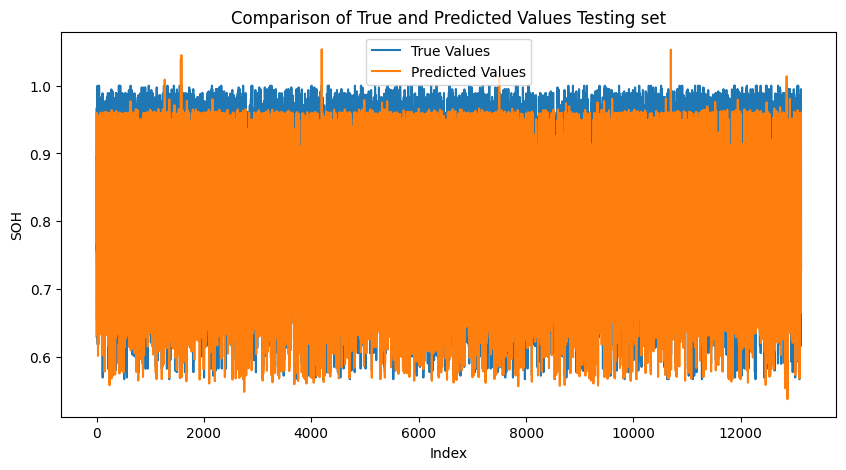

In [87]:
# testing the accuracy of model on thw test dataset
%matplotlib inline
predicted_y = SOH_model.predict(X_SOH_test)
true_y = y_SOH_test

mse = mean_squared_error(true_y, predicted_y)
mae = mean_absolute_error(true_y, predicted_y)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

plt.figure(figsize=(10, 5))

plt.plot(true_y, label="True Values")

plt.plot(predicted_y, label="Predicted Values")

plt.title("Comparison of True and Predicted Values Testing set")
plt.xlabel("Index")
plt.ylabel("SOH")
plt.legend()
plt.show()

In [88]:
# testing the accuracy of model on train dataset
predicted_y = SOH_model.predict(X_SOH_train)
true_y = y_SOH_train

mse = mean_squared_error(true_y, predicted_y)
mae = mean_absolute_error(true_y, predicted_y)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)



3281/3281 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step
Mean Squared Error: 0.0025318167249111932
Mean Absolute Error: 0.03884286916376904
Root Mean Squared Error: 0.05031716133598152


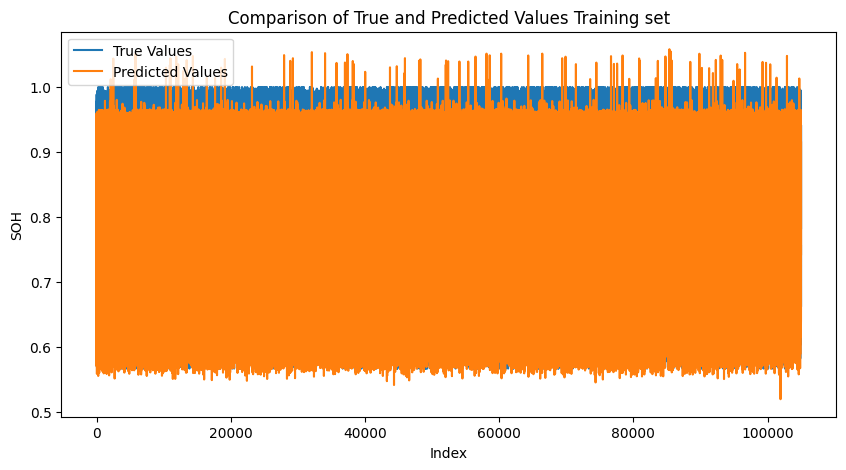

In [89]:
%matplotlib inline
plt.figure(figsize=(10, 5))

plt.plot(true_y, label="True Values")

plt.plot(predicted_y, label="Predicted Values")

plt.title("Comparison of True and Predicted Values Training set")
plt.xlabel("Index")
plt.ylabel("SOH")
plt.legend()
plt.show()

### Sonuç
Hem literatür taramalarından hem rmse değerlerini incelediğimizda lstm tabanlı sinir ağı modelimizin daha iyi sonuç verdiği için sinir ağını kullanmayı seçiyorum.


# SOC İÇİN MODEL OLUŞTURMA

In [90]:
# data split into train, test, validation
from sklearn.model_selection import train_test_split

# spliting data into train, test, validation
X_SOC_train, X_SOC_testval, y_SOC_train, y_SOC_testval = train_test_split(
    X, y_SOC, test_size=0.2, random_state=42
)

X_SOC_test, X_SOC_validation, y_SOC_test, y_SOC_validation = train_test_split(
    X_SOC_testval, y_SOC_testval, test_size=0.5, random_state=42
)

In [91]:
from flaml import AutoML
import numpy as np

# Reshape 3D data to 2D for AutoML
# Original shape: (n_samples, timesteps, features)
# New shape: (n_samples, timesteps * features)
X_train_2dd = X_SOH_train.reshape(X_SOC_train.shape[0], -1)
X_test_2dd = X_SOH_testval.reshape(X_SOC_testval.shape[0], -1)

# Initialize AutoML
automll = AutoML()

# Settings
automll_settings = {
    "time_budget": 60,  # 60 seconds - increased from 10 for better results
    "metric": "rmse",
    "task": "regression",
    "log_file_name": "battery_capacity.log",
}

# Train
automll.fit(X_train=X_train_2dd, y_train=y_SOC_train, **automll_settings)

# Predict and evaluate
y_predd = automll.predict(X_test_2dd)
print("Predictions:", y_predd)

# Show best model
print("\nBest model:", automll.model.estimator)

# Feature importance (if available)
if hasattr(automll.model.estimator, "feature_importances_"):
    print("\nFeature importances:", automll.model.estimator.feature_importances_)

[flaml.automl.logger: 04-11 02:39:55] {1728} INFO - task = regression
[flaml.automl.logger: 04-11 02:39:55] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-11 02:39:55] {1838} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 04-11 02:39:55] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 04-11 02:39:55] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-11 02:39:55] {2393} INFO - Estimated sufficient time budget=2322s. Estimated necessary time budget=17s.
[flaml.automl.logger: 04-11 02:39:55] {2442} INFO -  at 0.1s,	estimator lgbm's best error=0.0385,	best estimator lgbm's best error=0.0385
[flaml.automl.logger: 04-11 02:39:55] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-11 02:39:56] {2442} INFO -  at 0.8s,	estimator lgbm's best error=0.0385,	best estimator lgbm's best error=0.0385
[flaml.automl.logger: 04-11 02:39:56] {2

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 04-11 02:39:56] {2442} INFO -  at 0.8s,	estimator sgd's best error=0.0578,	best estimator lgbm's best error=0.0385
[flaml.automl.logger: 04-11 02:39:56] {2258} INFO - iteration 3, current learner sgd
[flaml.automl.logger: 04-11 02:39:56] {2442} INFO -  at 0.9s,	estimator sgd's best error=0.0495,	best estimator lgbm's best error=0.0385
[flaml.automl.logger: 04-11 02:39:56] {2258} INFO - iteration 4, current learner xgboost
[flaml.automl.logger: 04-11 02:39:56] {2442} INFO -  at 1.1s,	estimator xgboost's best error=0.0384,	best estimator xgboost's best error=0.0384
[flaml.automl.logger: 04-11 02:39:56] {2258} INFO - iteration 5, current learner extra_tree
[flaml.automl.logger: 04-11 02:39:56] {2442} INFO -  at 1.2s,	estimator extra_tree's best error=0.0166,	best estimator extra_tree's best error=0.0166
[flaml.automl.logger: 04-11 02:39:56] {2258} INFO - iteration 6, current learner rf
[flaml.automl.logger: 04-11 02:39:56] {2442} INFO -  at 1.4s,	estimator rf's best 

In [92]:
print("\nBest model:", automll.model.estimator)

# Feature importance (if available)
if hasattr(automll.model.estimator, "feature_importances_"):
    print("\nFeature importances:", automll.model.estimator.feature_importances_)


Best model: ExtraTreesRegressor(max_features=0.4539107862274748, max_leaf_nodes=7483,
                    n_estimators=101, n_jobs=-1, random_state=12032022)

Feature importances: [0.00000000e+00 2.07308699e-02 2.11199378e-03 1.23783081e-02
 1.68235195e-04 1.08316647e-02 6.11150285e-03 0.00000000e+00
 5.31019845e-02 1.18038898e-03 1.00132175e-02 1.85563944e-04
 3.06919654e-03 2.04080820e-03 0.00000000e+00 4.29486177e-02
 2.48469422e-03 5.20784735e-03 2.20396520e-04 1.38346821e-03
 7.91517535e-05 0.00000000e+00 5.04522723e-02 3.49783387e-04
 3.46973677e-02 2.01675821e-04 1.01334305e-02 4.37404668e-03
 0.00000000e+00 6.24060541e-02 8.50962698e-05 1.29275911e-02
 2.61929763e-04 2.60918537e-03 4.56096061e-04 0.00000000e+00
 1.12288176e-01 1.03885252e-03 1.90614618e-02 7.19265623e-04
 1.46410195e-02 7.91935693e-05 0.00000000e+00 8.43432465e-02
 7.67433503e-04 1.14931019e-02 1.83328316e-04 1.21110096e-02
 1.47387679e-04 0.00000000e+00 8.43236562e-02 2.50412460e-03
 1.90231990e-02 6.01203178

#### Sinir ağı tabanlı model

In [ ]:
from flaml import AutoML
import numpy as np

# architecture of the model
time_steps = X_SOC_train.shape[1]
features = X_SOC_train.shape[2]

model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(time_steps, features)))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(50, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(optimizer="adam", loss="mean_squared_error")


# training the model
history = model.fit(
    X_SOC_train,
    y_SOC_train,
    epochs=20,
    validation_data=(X_SOC_validation, y_SOC_validation),
    verbose=1,
)
model.save("SOC_LSTM.h5")

Epoch 1/20


/home/deniz/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3281/3281 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - loss: 0.0043 - val_loss: 0.0011
Epoch 2/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 49s 15ms/step - loss: 8.3551e-04 - val_loss: 0.0014
Epoch 3/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step - loss: 5.5451e-04 - val_loss: 5.6183e-04
Epoch 4/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step - loss: 4.5299e-04 - val_loss: 2.9834e-04
Epoch 5/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step - loss: 3.1756e-04 - val_loss: 1.3506e-04
Epoch 6/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step - loss: 1.7917e-04 - val_loss: 3.2867e-04
Epoch 7/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step - loss: 1.6506e-04 - val_loss: 4.3445e-04
Epoch 8/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step - loss: 1.6215e-04 - val_loss: 1.0210e-04
Epoch 9/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - loss: 1.4457e-04 - val_loss: 1.5309e-04
Epoch 10/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - loss: 1.2869e-04 - val_loss: 9.5645e-05
Epoch 11/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# loading the model
SOC_model = load_model("SOH_LSTM.h5")
SOC_model.summary()

In [ ]:

# testing the accuracy of model on thw test dataset
%matplotlib inline
predicted_y = SOC_model.predict(X_SOH_test)
true_y = y_SOC_test

mse = mean_squared_error(true_y, predicted_y)
mae = mean_absolute_error(true_y, predicted_y)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

plt.figure(figsize=(10, 5))

plt.plot(true_y, label="True Values")

plt.plot(predicted_y, label="Predicted Values")

plt.title("Comparison of True and Predicted Values Testing set")
plt.xlabel("Index")
plt.ylabel("SOC")
plt.legend()
plt.show()


In [ ]:
# testing the accuracy of model on train dataset
predicted_y = SOC_model.predict(X_SOH_train)
true_y = y_SOC_train

mse = mean_squared_error(true_y, predicted_y)
mae = mean_absolute_error(true_y, predicted_y)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)


%matplotlib inline
plt.figure(figsize=(10, 5))

plt.plot(true_y, label="True Values")

plt.plot(predicted_y, label="Predicted Values")

plt.title("Comparison of True and Predicted Values Training set")
plt.xlabel("Index")
plt.ylabel("SOC")
plt.legend()
plt.show()


# XAİ AÇIKLANABİLİR YAPAY ZEKA
Bu alanın asıl amacı ,blackbox modelleri açıklayabilmek için çeşitli yöntemleri kullanarak model davranışlarını anlamlandırmaktır.